In [28]:
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import PIL
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import os
from pathlib import Path
import torchvision
import matplotlib.pyplot as plt

In [3]:
np.random.seed(123)
torch.manual_seed(123)
random.seed(123)

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
models_dir = Path("./models")
logs_dir = Path("./logs")

models_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)

In [6]:
def plot_images(images, titles, texts):
    N_cols = len(images)
    N_rows = len(images[0])
    
    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))
    
    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])
    
    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()

In [192]:
# Load pretrained model on ImageNet
model = torch.hub.load('pytorch/vision', 'resnext101_32x8d', pretrained=True)
model.eval()

Using cache found in C:\Users\Zelong/.cache\torch\hub\pytorch_vision_main
C:\Users\Zelong\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to C:\Users\Zelong/.cache\torch\hub\checkpoints\resnext101_32x8d-8ba56ff5.pth
100%|███████████████████████████████████████████████████████████████████████████████| 340M/340M [00:34<00:00, 10.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [50]:
!python -m wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt


Saved under imagenet_classes.txt


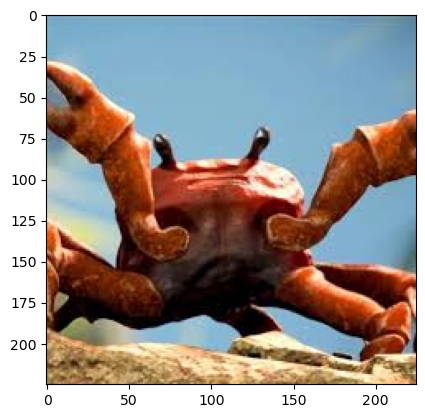

In [208]:
img = Image.open('crab.jpg')
plt.imshow(img)

In [246]:
# stats from https://pytorch.org/vision/main/models/generated/torchvision.models.resnext101_32x8d.html
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [247]:
preprocess = transforms.Compose([
                transforms.Resize(232),  
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

In [261]:
img_tensor = preprocess(img)
# create a mini-batch 
img_batch  = img_tensor.unsqueeze(0)

In [262]:
var = Variable(img_batch, requires_grad=True)

In [267]:
def get_results(output):
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # https://pytorch.org/hub/pytorch_vision_resnext/
    # Read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    
    top1_prob, top1_catid = torch.topk(probabilities, 1)
    top1_catid = int(top1_catid)

    return top1_catid


In [268]:
output = model.forward(var)
true_catid = get_results(output)

rock crab 0.4819836914539337
king crab 0.13524703681468964
fiddler crab 0.13208091259002686
Dungeness crab 0.027286462485790253
ibex 0.017351454123854637


In [269]:
target = Variable(torch.LongTensor([true_catid]), requires_grad=False)
loss = torch.nn.CrossEntropyLoss()
loss_bac = loss(output, target)
loss_bac.backward(retain_graph=True)

In [378]:
eps = 0.05
grad = torch.sign(var.grad.data)
img_adver = var.data + eps * grad

In [379]:
var_adver = Variable(img_adver, requires_grad=True)
output = model.forward(var_adver)
true_catid = get_results(output)

ox 0.10093897581100464
oxcart 0.06160465255379677
howler monkey 0.04572708532214165
Egyptian cat 0.044331878423690796
lesser panda 0.04042961075901985


In [367]:
def retrieve_img(img):
    img = img.squeeze(0)
    img = img * torch.FloatTensor(std).view(3,1,1) + torch.FloatTensor(mean).view(3,1,1)
    img = np.transpose(img, (1,2,0))
    img = np.clip(img, 0, 1)
    img = img.numpy()
    return img

In [356]:
img_adver = retrieve_img(img_adver)

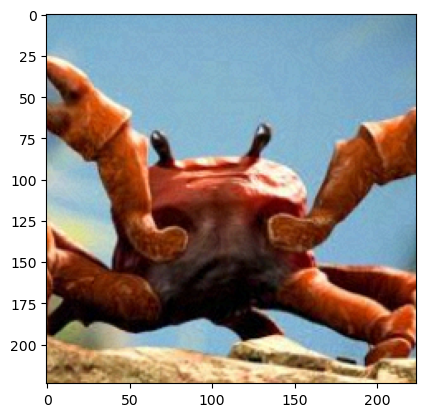

In [348]:
plt.imshow(img_adver)

In [323]:
plt.imsave('adver.jpg', img_adver) 

In [368]:
noise = retrieve_img(grad)

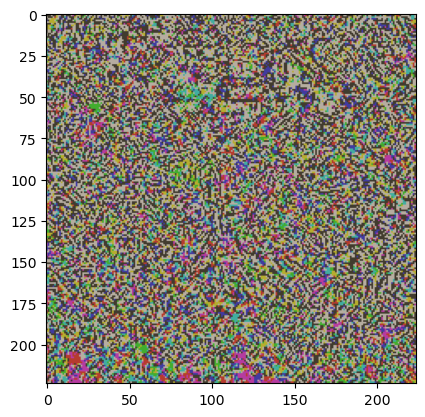

In [370]:
plt.imshow(noise)

In [371]:
plt.imsave('noise.jpg', noise) 